# Librerías

In [ ]:
pip install azure-storage-blob

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from azure.storage.blob import BlobServiceClient, ContainerClient
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import io
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, f1_score
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pointbiserialr, spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import  f_classif, chi2
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier


# Configuración de Variables

In [3]:
# Datos de conexión
STORAGE_ACCOUNT_NAME = "storageraweafit"
STORAGE_ACCOUNT_KEY = "WsCUy0/jJ3Em+DdFBSvJ4Vy/K0Wzw4smzMMsLjbk03B1KZtBGKuswa+PQmF1nFuxNlxbuV7+xw00+AStrtzkYA=="
CONTAINER_NAME = "stock"
# Crear cliente de servicio Blob
connection_string = f"DefaultEndpointsProtocol=https;AccountName={STORAGE_ACCOUNT_NAME};AccountKey={STORAGE_ACCOUNT_KEY};EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

# Preparación de los datos

## Extracción de datos

La siguiente función se encarga de leer los archivos `.csv` del Blob storage y cargarlos como un dataset de Pandas

In [4]:
def get_data_frame(symbol, containerName='stock'):
  container_client = blob_service_client.get_container_client(containerName)
  blob_client = container_client.get_blob_client(r'{}.csv'.format(symbol))
  blob_data = blob_client.download_blob().readall()
  csv_data = blob_data.decode("utf-8")
  return pd.read_csv(StringIO(csv_data))

La siguiente función se encarga de formar un solo dataset con todos los simbolos requeridos

In [5]:
def extract_raw(symbols):
  raw=pd.DataFrame()
  raw = get_data_frame(symbols[0])['timestamp']

  for symbol in symbols:
    df = get_data_frame(symbol)
    df.columns=df.columns+r'_{}'.format(symbol)
    raw = pd.merge(raw, df, left_on='timestamp', right_on=df.columns[0], how='left')
    raw=raw[raw.columns.drop(list(raw.filter(regex='timestamp_')))]
    raw['ts'] = pd.to_datetime(raw['timestamp'], errors='coerce')
    raw['year']=raw['ts'].dt.year
    raw['month']=raw['ts'].dt.month
    raw['day']=raw['ts'].dt.month
    # raw.drop(columns=['ts'], inplace=True)
  return raw

Hay unos datos muy antiguos en el dataset que no tienen importancia, o que se encuentran como tipo `NAN` para algunos simbolos, por tanto se crea el filtro para eliminarlos

In [6]:
def filter_year(dataset, from_year=2014):
  filtered = dataset[dataset['year']>from_year]
  return filtered

En caso de que sea necesario realizar la imputación de datos se define una función para hacerlo

In [7]:
def impute_data(dataset):
  imputed_data=dataset.copy()
  columns = np.array(imputed_data.drop(columns=['year', 'month', 'timestamp','day']).isna().sum(axis=0).reset_index()['index'])
  for column in columns:
      if dataset[column].isnull().any():
          mean_values = imputed_data.groupby(['year', 'month'])[column].transform('mean')
          imputed_data[column] = imputed_data[column].fillna(mean_values)
  return imputed_data

# Preparación y limpieza de los datos

## Extracción de los datos

Definimos una lista que contendrá los simbolos que necesitamos extraer desde la zona `raw` del **Blob Storage**

In [8]:
SYMBOLS=['IBM','AAPL', 'NVDA', 'MSFT', 'EUR', 'JPY', 'SPY']

Realizamos la extracción de los datos haciendo un llamado a la función `extract raw`

In [9]:
raw_data=extract_raw(SYMBOLS)

In [14]:
raw_data

,timestamp,value_IBM,ts,year,month,day,open_AAPL,high_AAPL,low_AAPL,close_AAPL,...,close_EUR,open_JPY,high_JPY,low_JPY,close_JPY,open_SPY,high_SPY,low_SPY,close_SPY,volume_SPY
0,2024-11-22,4.58,2024-11-22,2024,11,11,228.06,230.7199,228.0600,229.87,...,NaN,NaN,NaN,NaN,NaN,593.66,596.150,593.1525,595.51,38226390.0
1,2024-11-21,4.58,2024-11-21,2024,11,11,228.88,230.1550,225.7103,228.52,...,0.95517,154.218,154.97900,153.97501,154.218,593.40,595.120,587.4500,593.67,46750285.0
2,2024-11-20,4.58,2024-11-20,2024,11,11,228.06,229.9300,225.8900,229.00,...,0.94821,155.295,155.27000,153.95200,155.295,590.38,590.790,584.6300,590.50,50032576.0
3,2024-11-19,4.58,2024-11-19,2024,11,11,226.98,230.1600,226.6600,228.28,...,0.94272,154.718,155.87199,154.61200,154.718,584.71,591.045,584.0300,590.30,49412046.0
4,2024-11-18,4.58,2024-11-18,2024,11,11,225.25,229.7400,225.1700,228.02,...,0.94385,154.617,154.64500,153.39700,154.617,586.22,589.490,585.3400,588.15,37084081.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25708,1954-07-05,0.88,1954-07-05,1954,7,7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25709,1954-07-04,1.25,1954-07-04,1954,7,7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25710,1954-07-03,1.25,1954-07-03,1954,7,7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25711,1954-07-02,1.25,1954-07-02,1954,7,7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En el dataset se presenta un error con las fechas en las cuales se empezó a realizar la colecta de los datos, por ejemplo para la tase de cambio de Dólares a Euros, la información empieza a partir del año 2014, mientras que para otros símbolos, por ejemplo para IBM la información se encuentra a partir de varios años atrás

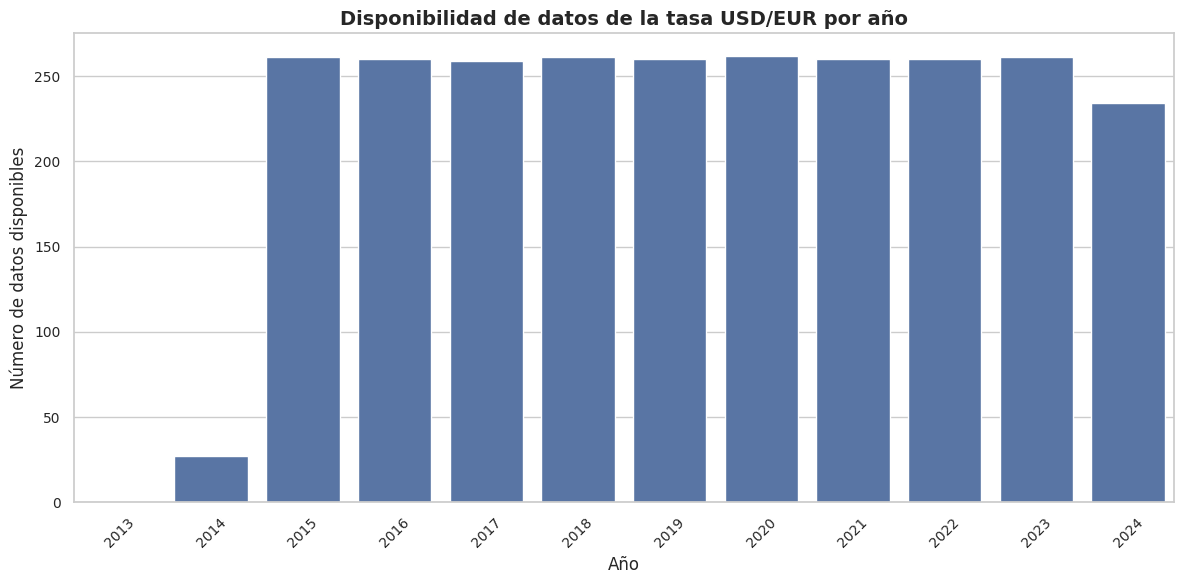

In [13]:
sns.set_theme(style="whitegrid")  
plt.figure(figsize=(12, 6))

eur_data = raw_data[['low_EUR', 'year']].groupby(['year'])['low_EUR'].count().reset_index()

sns.barplot(data=eur_data[eur_data['year'] > 2012], x='year', y='low_EUR')
# Personalizar etiquetas y título
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de datos disponibles', fontsize=12)
plt.title("Disponibilidad de datos de la tasa USD/EUR por año", fontsize=14, fontweight='bold')

# Ajustar etiquetas del eje X
plt.xticks(fontsize=10, rotation=45)  # Rotar etiquetas para mayor claridad
plt.yticks(fontsize=10)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
plt.show()

Este problema también se repite con otros símbolos, por tanto, se tomarán los datos a partir del 2015

In [21]:
filtered_year=filter_year(raw_data, 2014)

In [22]:
filtered_year

,timestamp,value_IBM,ts,year,month,day,open_AAPL,high_AAPL,low_AAPL,close_AAPL,...,close_EUR,open_JPY,high_JPY,low_JPY,close_JPY,open_SPY,high_SPY,low_SPY,close_SPY,volume_SPY
0,2024-11-22,4.58,2024-11-22,2024,11,11,228.06,230.7199,228.0600,229.87,...,NaN,NaN,NaN,NaN,NaN,593.66,596.150,593.1525,595.51,38226390.0
1,2024-11-21,4.58,2024-11-21,2024,11,11,228.88,230.1550,225.7103,228.52,...,0.95517,154.218,154.97900,153.97501,154.218,593.40,595.120,587.4500,593.67,46750285.0
2,2024-11-20,4.58,2024-11-20,2024,11,11,228.06,229.9300,225.8900,229.00,...,0.94821,155.295,155.27000,153.95200,155.295,590.38,590.790,584.6300,590.50,50032576.0
3,2024-11-19,4.58,2024-11-19,2024,11,11,226.98,230.1600,226.6600,228.28,...,0.94272,154.718,155.87199,154.61200,154.718,584.71,591.045,584.0300,590.30,49412046.0
4,2024-11-18,4.58,2024-11-18,2024,11,11,225.25,229.7400,225.1700,228.02,...,0.94385,154.617,154.64500,153.39700,154.617,586.22,589.490,585.3400,588.15,37084081.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,2015-01-05,0.12,2015-01-05,2015,1,1,108.29,108.6500,105.4100,106.25,...,0.83759,119.416,119.49700,118.68000,119.425,204.17,204.370,201.3500,201.72,169632646.0
3610,2015-01-04,0.12,2015-01-04,2015,1,1,NaN,NaN,NaN,NaN,...,0.83707,120.389,120.60800,119.41100,120.434,NaN,NaN,NaN,NaN,NaN
3611,2015-01-03,0.12,2015-01-03,2015,1,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3612,2015-01-02,0.12,2015-01-02,2015,1,1,111.39,111.4400,107.3500,109.33,...,NaN,NaN,NaN,NaN,NaN,206.38,206.880,204.1800,205.43,121465865.0


El siguiente paso a seguir es realizar la imputación de los datos. Para esto es necesario primero identificar la cantidad de datos nulos que se tienen presentes en el dataset en las distintas características, y también como es la distribución de estos valores en el tiempo.

Por tanto, vamos a ordenar el dataset según la cantidad de datos disponibles que tengamos por mes

In [24]:
nan_columns=np.array(filtered_year.isna().sum().reset_index()['index'])
valid_columns = [col for col in nan_columns if col not in ['year', 'month']]
total_data = filtered_year.groupby(['year', 'month'])[valid_columns].count().reset_index()
total_data.min().sort_values().reset_index().head(8)

,index,0
0,month,1
1,open_JPY,15
2,high_JPY,15
3,low_JPY,15
4,close_JPY,15
5,open_EUR,15
6,low_EUR,15
7,high_EUR,15


Con el resultado anterior podemos concluir, que en el peor de los casos vamos a tener unos datos nulos equivalentes al 50% de los datos, por ejemplo para la columna de `low_EUR` tenemos el siguiente comportamiento

In [127]:
total_data

,year,month,timestamp,value_IBM,ts,day,open_AAPL,high_AAPL,low_AAPL,close_AAPL,...,close_EUR,open_JPY,high_JPY,low_JPY,close_JPY,open_SPY,high_SPY,low_SPY,close_SPY,volume_SPY
0,2015,1,31,31,31,31,20,20,20,20,...,21,21,21,21,21,20,20,20,20,20
1,2015,2,28,28,28,28,19,19,19,19,...,20,20,20,20,20,19,19,19,19,19
2,2015,3,31,31,31,31,22,22,22,22,...,23,23,23,23,23,22,22,22,22,22
3,2015,4,30,30,30,30,21,21,21,21,...,22,22,22,22,22,21,21,21,21,21
4,2015,5,31,31,31,31,20,20,20,20,...,21,21,21,21,21,20,20,20,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2024,7,31,31,31,31,22,22,22,22,...,23,23,23,23,23,22,22,22,22,22
115,2024,8,31,31,31,31,22,22,22,22,...,21,21,21,21,21,22,22,22,22,22
116,2024,9,30,30,30,30,20,20,20,20,...,22,22,22,22,22,20,20,20,20,20
117,2024,10,31,31,31,31,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23


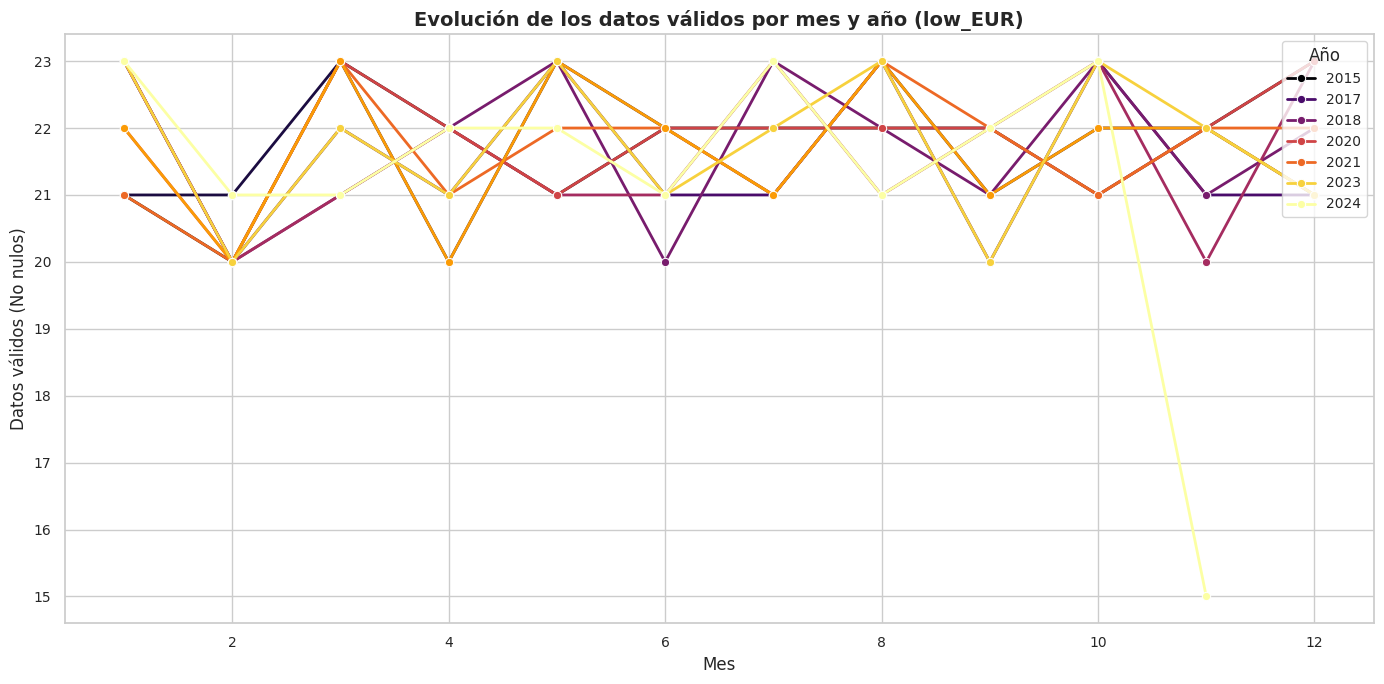

In [26]:
sns.set_theme(style="whitegrid") 
plt.figure(figsize=(14, 7))

sns.lineplot(
    data=total_data,
    x='month',
    y='low_EUR',
    hue='year',
    palette='inferno',
    marker='o',  
    linewidth=2  
)

plt.xlabel('Mes', fontsize=12)
plt.ylabel('Datos válidos (No nulos)', fontsize=12)
plt.title('Evolución de los datos válidos por mes y año (low_EUR)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(
    title='Año',
    title_fontsize=12,
    fontsize=10,
    loc='upper right',
    frameon=True
)

plt.tight_layout()  
plt.show()

In [134]:
curated_data=impute_data(filtered_year)
curated_data

,timestamp,value_IBM,ts,year,month,day,open_AAPL,high_AAPL,low_AAPL,close_AAPL,...,close_EUR,open_JPY,high_JPY,low_JPY,close_JPY,open_SPY,high_SPY,low_SPY,close_SPY,volume_SPY
0,2024-11-22,4.58,2024-11-22,2024,11,11,228.06000,230.719900,228.06000,229.8700,...,0.937347,153.996401,154.707134,153.340601,153.996401,593.6600,596.150,593.1525,595.5100,3.822639e+07
1,2024-11-21,4.58,2024-11-21,2024,11,11,228.88000,230.155000,225.71030,228.5200,...,0.955170,154.218000,154.979000,153.975010,154.218000,593.4000,595.120,587.4500,593.6700,4.675028e+07
2,2024-11-20,4.58,2024-11-20,2024,11,11,228.06000,229.930000,225.89000,229.0000,...,0.948210,155.295000,155.270000,153.952000,155.295000,590.3800,590.790,584.6300,590.5000,5.003258e+07
3,2024-11-19,4.58,2024-11-19,2024,11,11,226.98000,230.160000,226.66000,228.2800,...,0.942720,154.718000,155.871990,154.612000,154.718000,584.7100,591.045,584.0300,590.3000,4.941205e+07
4,2024-11-18,4.58,2024-11-18,2024,11,11,225.25000,229.740000,225.17000,228.0200,...,0.943850,154.617000,154.645000,153.397000,154.617000,586.2200,589.490,585.3400,588.1500,3.708408e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,2015-01-05,0.12,2015-01-05,2015,1,1,108.29000,108.650000,105.41000,106.2500,...,0.837590,119.416000,119.497000,118.680000,119.425000,204.1700,204.370,201.3500,201.7200,1.696326e+08
3610,2015-01-04,0.12,2015-01-04,2015,1,1,111.16375,112.253965,109.33175,110.6415,...,0.837070,120.389000,120.608000,119.411000,120.434000,202.9765,204.073,201.1380,202.5825,1.591753e+08
3611,2015-01-03,0.12,2015-01-03,2015,1,1,111.16375,112.253965,109.33175,110.6415,...,0.859630,118.348381,118.856000,117.742619,118.350762,202.9765,204.073,201.1380,202.5825,1.591753e+08
3612,2015-01-02,0.12,2015-01-02,2015,1,1,111.39000,111.440000,107.35000,109.3300,...,0.859630,118.348381,118.856000,117.742619,118.350762,206.3800,206.880,204.1800,205.4300,1.214659e+08


# Envío de datos a la Zona curada

Una vez los datos `Raw` han sido procesados y tratados, se envían al almacenamiento en un `blob storage` encargado de mantener los datos curados

In [136]:
output = io.StringIO()
output = curated_data.to_csv (index_label="idx", encoding = "utf-8")
CURATED_CONTAINER = "curateddata"
# Crear cliente de servicio Blob
connection_string = f"DefaultEndpointsProtocol=https;AccountName={STORAGE_ACCOUNT_NAME};AccountKey={STORAGE_ACCOUNT_KEY};EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

blob_block = ContainerClient.from_connection_string(conn_str = connection_string, container_name = CURATED_CONTAINER)
name = 'imputed_data.csv'
blob_block.upload_blob(name, output, overwrite=True, encoding='utf-8')

# Desarrollo del modelo

## Ingeniería de características

### Test de causalidad

Se realizará el test de causalidad de Granger para intuir cuales pueden ser las variables que se pueden incluir dentro del modelo.

El test de causalidad consiste en comprobar si los resultados de una variable sirven para predecir a otra variable. En el caso de una serie temporal se comprueba si el comportamiento actual y pasado de una serie `A` ayuda a predecir el comportamiento de otra serie temporal `B`.
Para empezar, seleccionamos los datos de `close` pertenecientes a los símbolos seleccionados:

In [137]:
df_validacion_granger = curated_data.copy()
df_validacion_granger = df_validacion_granger[['close_AAPL','close_EUR','close_NVDA','close_SPY','close_MSFT','close_JPY','year','ts']]

Después de seleccionado el conjunto de datos realizamos un chequeo visual de los símbolos para intentar hallar una relación entre ellos

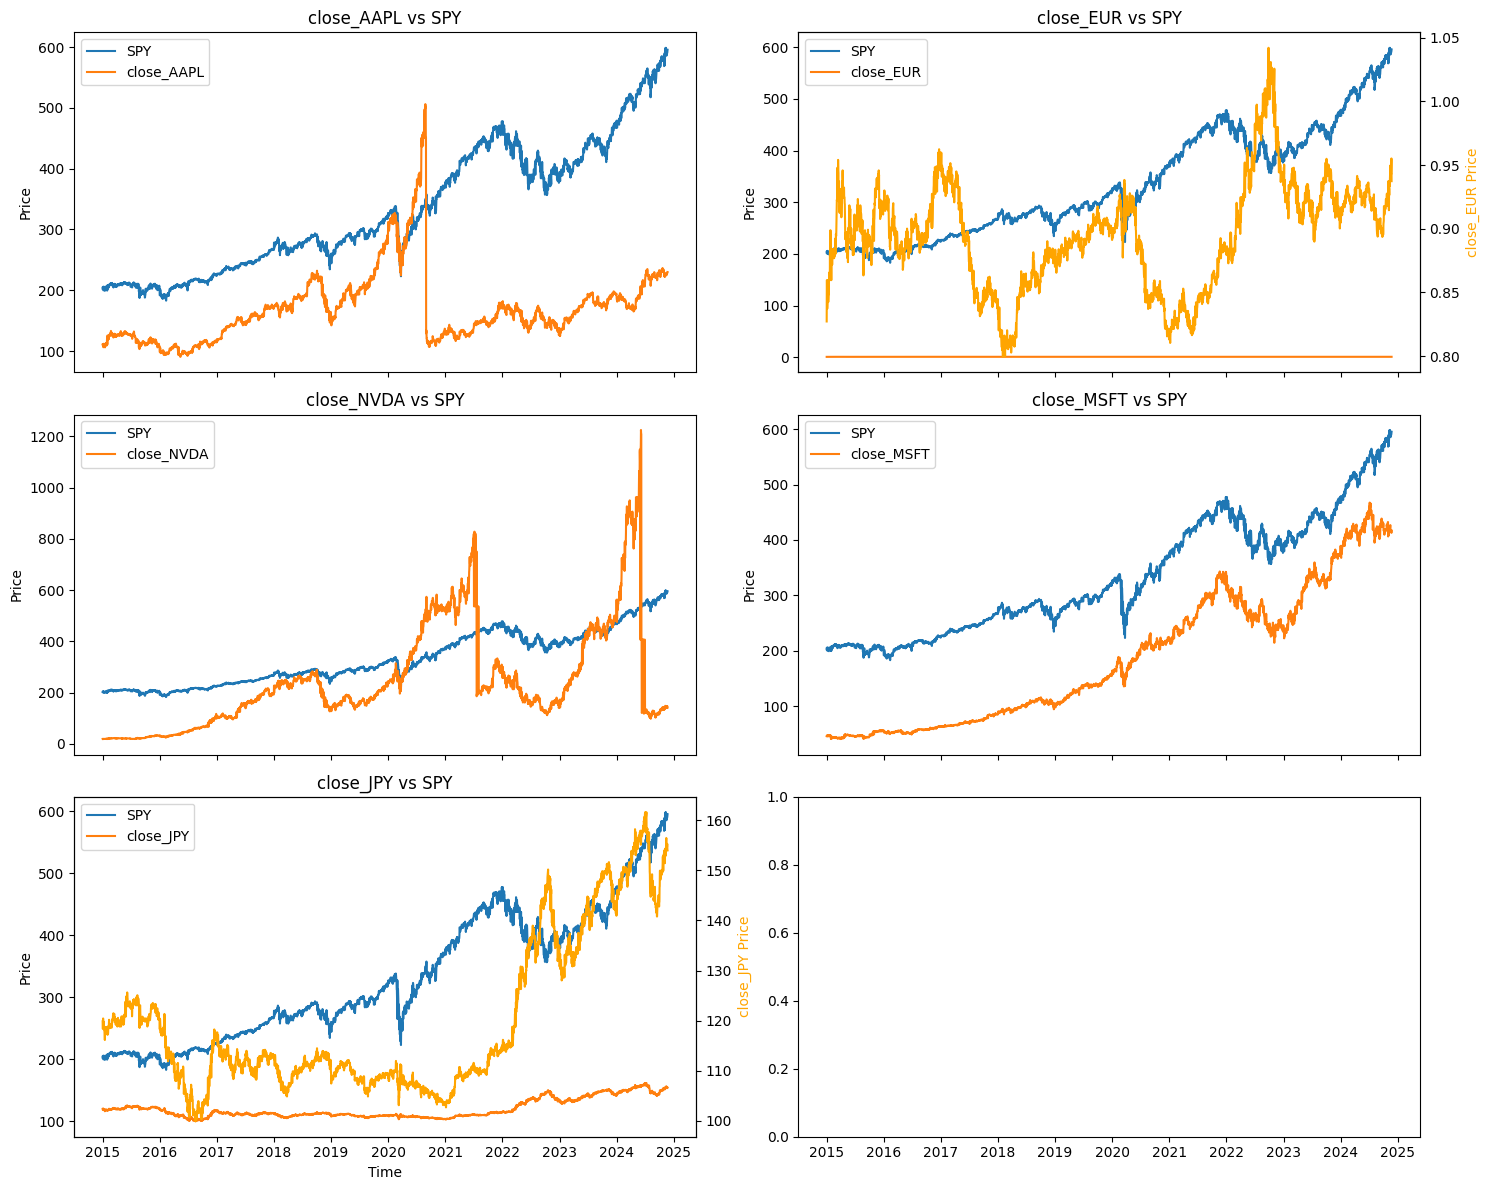

In [222]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharex=True)
axes = axes.flatten()

# Define the series to plot against SPY
series_to_plot = ['close_AAPL', 'close_EUR', 'close_NVDA', 'close_MSFT', 'close_JPY']

# Iterate through the series and plot them against SPY
for i, series in enumerate(series_to_plot):
    ax = axes[i]
    sns.lineplot(x='ts', y='close_SPY', data=df_validacion_granger, ax=ax, label='SPY')
    sns.lineplot(x='ts', y=series, data=df_validacion_granger, ax=ax, label=series)
    ax.set_title(f'{series} vs SPY')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.legend()

    # Condicional para ejes secundarios en EUR y JPY
    if series in ['close_EUR', 'close_JPY']:
        ax2 = ax.twinx()
        sns.lineplot(x='ts', y=series, data=df_validacion_granger, ax=ax2, color='orange')
        ax2.set_ylabel(f'{series} Price', color='orange')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Calculamos las diferencias entre las filas con el método de `.dif()`

In [226]:
# Calcular primeras diferencias
df_diff = df_validacion_granger.set_index('ts').diff().dropna().reset_index()

# Lista de series que quieres analizar
series_to_test = ['close_AAPL', 'close_EUR', 'close_NVDA', 'close_MSFT', 'close_JPY']
# Realizar el test de causalidad de Granger
max_lag = 3  # Número máximo de lags que deseas considerar

for series in series_to_test:
    print(f"Granger Causality Test: {series} -> close_SPY")
    granger_test = grangercausalitytests(
        df_diff[['close_SPY', series]],
        max_lag,
        verbose=True
    )
    print("\n")

Granger Causality Test: close_AAPL -> close_SPY

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9195  , p=0.1660  , df_denom=3609, df_num=1
ssr based chi2 test:   chi2=1.9211  , p=0.1657  , df=1
likelihood ratio test: chi2=1.9206  , p=0.1658  , df=1
parameter F test:         F=1.9195  , p=0.1660  , df_denom=3609, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3059  , p=0.0018  , df_denom=3606, df_num=2
ssr based chi2 test:   chi2=12.6293 , p=0.0018  , df=2
likelihood ratio test: chi2=12.6073 , p=0.0018  , df=2
parameter F test:         F=6.3059  , p=0.0018  , df_denom=3606, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7019  , p=0.0112  , df_denom=3603, df_num=3
ssr based chi2 test:   chi2=11.1274 , p=0.0111  , df=3
likelihood ratio test: chi2=11.1103 , p=0.0111  , df=3
parameter F test:         F=3.7019  , p=0.0112  , df_denom=3603, df_num=3


Granger Causality Test: close_EUR -> c

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## Tratamiento como modelo de clasificación

### Tratamiento para la variable close

En este caso se calcularán indicadores técnicos enfocados en la columna `close_SPY` tales como:
* **EMA**: *Exponential Moving average* Este método es utilizado para pronosticar la demanda de un producto. Genera un ponderado considerando una ventana de tiempo, dando un mayor peso a los valores más cercanos en el tiempo.

* **RSI**: *Relative Strength Index*  Mide la fuerza y velocidad de los movimientos para estimar la sobrecompra o sobreventa de un activo, tomando valores entre 0 y 100.

* **MACD**: *Moving Average Convergence Divergence* Es otro indicador técnico que consiste en hallar la diferencia entre un **EMA** rápido (ventana temporal de 12 días) y un **EMA** lento (ventana temporal de 26 días). Este método ayuda a confirmar tendencias y detectar cambios de dirección.

In [144]:
# Desfasar los precios de cierre en un día
curated_data['Close_shifted'] = curated_data['close_SPY'].shift(1)

# SMA de 50 días usando datos desfasados
curated_data['SMA_50'] = curated_data['Close_shifted'].rolling(window=50).mean()

# EMA de 50 días usando datos desfasados
curated_data['EMA_50'] = curated_data['Close_shifted'].ewm(span=50, adjust=False).mean()

# RSI de 14 días usando datos desfasados
delta = curated_data['Close_shifted'].diff(1)
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
RS = gain / loss
curated_data['RSI'] = 100 - (100 / (1 + RS))

# MACD usando datos desfasados
curated_data['EMA_12'] = curated_data['Close_shifted'].ewm(span=12, adjust=False).mean()
curated_data['EMA_26'] = curated_data['Close_shifted'].ewm(span=26, adjust=False).mean()
curated_data['MACD'] = curated_data['EMA_12'] - curated_data['EMA_26']
curated_data['Signal'] = curated_data['MACD'].ewm(span=9, adjust=False).mean()

curated_data['volume_SPY_shifted'] = curated_data['volume_SPY'].shift(1)
curated_data['High_SPY_shifted'] = curated_data['high_SPY'].shift(1)
curated_data['Low_SPY_shifted'] = curated_data['low_SPY'].shift(1)

# Parámetros
n = 9  # Período para las EMAs
p = 25  # Período para el Mass Index

# Calcular el rango diario (High - Low) desfasado
curated_data['Range'] = (curated_data['High_SPY_shifted'] - curated_data['Low_SPY_shifted']).shift(1)

# Single EMA (S)
curated_data['EMA_Range'] = curated_data['Range'].ewm(span=n, adjust=False).mean()

# Double EMA (D)
curated_data['EMA_EMA_Range'] = curated_data['EMA_Range'].ewm(span=n, adjust=False).mean()

# Calcular la relación S/D
curated_data['Ratio'] = curated_data['EMA_Range'] / curated_data['EMA_EMA_Range']

# Mass Index (MI)
curated_data['Mass_Index'] = curated_data['Ratio'].rolling(window=p).sum()


#Bandas Bolinger
curated_data['SMA_20'] = curated_data['Close_shifted'].rolling(window=20).mean()
curated_data['BB_Upper'] = curated_data['SMA_20'] + 2 * curated_data['Close_shifted'].rolling(window=20).std()
curated_data['BB_Lower'] = curated_data['SMA_20'] - 2 * curated_data['Close_shifted'].rolling(window=20).std()


#Medidas de volatilidad
curated_data['True_Range'] = curated_data[['High_SPY_shifted', 'Close_shifted', 'Low_SPY_shifted']].max(axis=1) - \
                             curated_data[['High_SPY_shifted', 'Close_shifted', 'Low_SPY_shifted']].min(axis=1)


curated_data['ATR'] = curated_data['True_Range'].rolling(window=14).mean()


#Mas rezagos

curated_data['Close_lag3'] = curated_data['close_SPY'].shift(3)
curated_data['Close_lag5'] = curated_data['close_SPY'].shift(5)


curated_data['Day_of_Week'] = pd.to_datetime(curated_data['timestamp'], errors='coerce').dt.dayofweek

### Cálculo variables externas al SYP

In [145]:
for lag in [1,3,4,5]:  # Rezagos de 1 y 2 días
    curated_data[f'close_EUR-{lag}'] = curated_data['close_EUR'].shift(lag*-1)

for lag in [1,2,3,4,5]:  # Rezagos de 1 y 2 días
    curated_data[f'close_AAPL-{lag}'] = curated_data['close_AAPL'].shift(lag*-1)

In [147]:
# RSI de 14 días usando datos desfasados para tasa de cambio del EUR
delta = curated_data['close_EUR-1'].diff(1)
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
RS = gain / loss
curated_data['RSI_EUR_USD'] = 100 - (100 / (1 + RS))


# RSI de 14 días usando datos desfasados para AAPL
delta = curated_data['close_AAPL-1'].diff(1)
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
RS = gain / loss
curated_data['RSI_AAPL'] = 100 - (100 / (1 + RS))

### Indicadores basados en volumen

In [ ]:
# Media Móvil del Volumen (SMA Volumen):
curated_data['Volume_SMA_20'] = curated_data['volume_SPY_shifted'].rolling(window=20).mean()

# Volumen Relativo (Relative Volume):
curated_data['Relative_Volume'] = curated_data['volume_SPY_shifted'] / curated_data['volume_SPY_shifted'].rolling(window=20).mean()


# Oscilador de Volumen (Volume Oscillator):
short_window = 12
long_window = 26

curated_data['Volume_EMA_Short'] = curated_data['volume_SPY_shifted'].ewm(span=short_window, adjust=False).mean()
curated_data['Volume_EMA_Long'] = curated_data['volume_SPY_shifted'].ewm(span=long_window, adjust=False).mean()
curated_data['Volume_Oscillator'] = curated_data['Volume_EMA_Short'] - curated_data['Volume_EMA_Long']


#  Volumen Acumulado (Accumulation/Distribution Indicator - AD):
curated_data['Money_Flow_Multiplier'] = ((curated_data['Close_shifted'] - curated_data['Low_SPY_shifted']) - (curated_data['High_SPY_shifted'] - curated_data['Close_shifted'])) / (curated_data['High_SPY_shifted'] - curated_data['Low_SPY_shifted'])
curated_data['Money_Flow_Volume'] = curated_data['Money_Flow_Multiplier'] * curated_data['volume_SPY_shifted']
curated_data['Accumulation_Distribution'] = curated_data['Money_Flow_Volume'].cumsum()

#Volatilidad del volumen
curated_data['Volume_Volatility'] = curated_data['volume_SPY_shifted'].rolling(window=20).std()

# Índice de Flujo de Dinero (Money Flow Index - MFI)

curated_data['Typical_Price'] = (curated_data['High_SPY_shifted'] + curated_data['Low_SPY_shifted'] + curated_data['Close_shifted']) / 3
curated_data['Money_Flow'] = curated_data['Typical_Price'] * curated_data['volume_SPY_shifted']

# Separar flujo positivo y negativo
positive_flow = curated_data['Money_Flow'].where(curated_data['Typical_Price'].diff() > 0, 0)
negative_flow = curated_data['Money_Flow'].where(curated_data['Typical_Price'].diff() <= 0, 0)

# Media móvil de flujo
positive_flow_sum = positive_flow.rolling(window=14).sum()
negative_flow_sum = negative_flow.rolling(window=14).sum()

# Índice de flujo de dinero
curated_data['MFI'] = 100 - (100 / (1 + (positive_flow_sum / negative_flow_sum)))
curated_data['BGI'] = np.where(curated_data['close_SPY'] - curated_data['close_SPY_t-1'] > 0, 0, 1)

In [153]:
df_temp = curated_data.dropna()
df_temp = df_temp[df_temp['year']!=2020]

In [155]:
df_temp = df_temp[['close_SPY_t-1', 'BGI', 'Close_shifted', 'SMA_50',
       'EMA_50', 'RSI', 'EMA_12', 'EMA_26', 'MACD', 'Signal',
       'volume_SPY_shifted', 'High_SPY_shifted', 'Low_SPY_shifted', 'Range',
       'EMA_Range', 'EMA_EMA_Range', 'Ratio', 'Mass_Index', 'SMA_20',
       'BB_Upper', 'BB_Lower', 'True_Range', 'ATR', 'Close_lag3', 'Close_lag5',
       'Day_of_Week', 'close_EUR-1', 'close_EUR-3', 'close_EUR-4',
       'close_EUR-5', 'close_AAPL-1', 'close_AAPL-2', 'close_AAPL-3',
       'close_AAPL-4', 'close_AAPL-5', 'RSI_EUR_USD', 'RSI_AAPL',
       'Volume_SMA_20', 'Relative_Volume', 'Volume_EMA_Short',
       'Volume_EMA_Long', 'Volume_Oscillator', 'Money_Flow_Multiplier',
       'Money_Flow_Volume', 'Accumulation_Distribution', 'Volume_Volatility',
       'Typical_Price', 'Money_Flow', 'MFI']]

### PCA

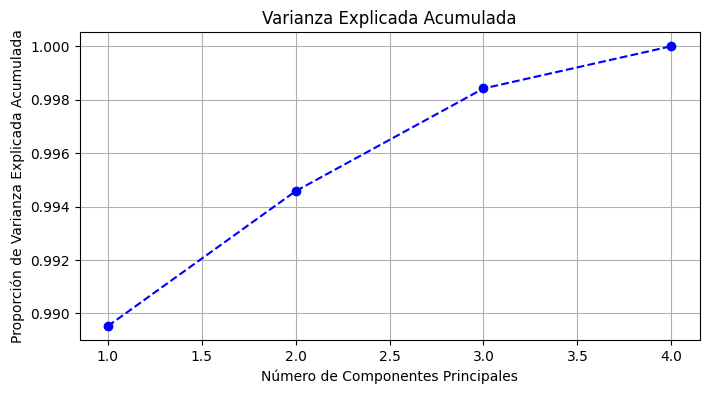

In [157]:
columnas = ['close_EUR-1', 'close_EUR-3', 'close_EUR-4', 'close_EUR-5']
X = df_temp[columnas]

# Aplicar PCA con todas las componentes posibles
pca_full = PCA()
pca_full.fit(X)

# Transformar datos usando todas las componentes
X_pca_full = pca_full.transform(X)

# Varianza explicada acumulada
explained_variance_cumsum = np.cumsum(pca_full.explained_variance_ratio_)

# Gráfico 1: Varianza explicada acumulada
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_cumsum) + 1), explained_variance_cumsum, marker='o', linestyle='--', color='b')
plt.title('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada Acumulada')
plt.grid(True)
plt.show()


In [158]:
pca = PCA(n_components=1)
pca_componente1 = pca.fit_transform(X)

# Agregar la primera componente al DataFrame original
df_temp['PCA_EUR'] = pca_componente1

/tmp/ipykernel_2248/3201246833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['PCA_EUR'] = pca_componente1


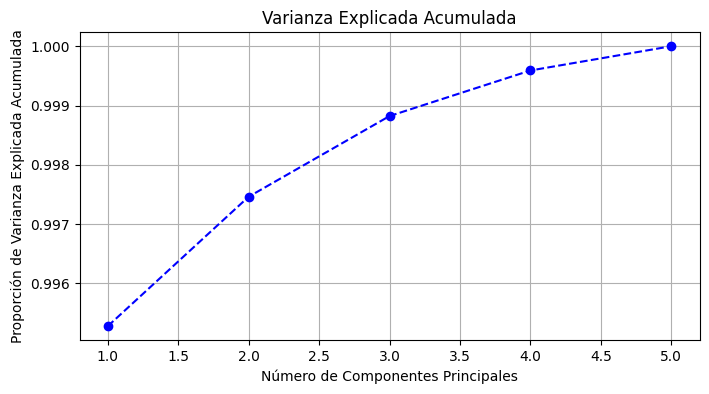

In [159]:
### PCA para AAPL

columnas = ['close_AAPL-1', 'close_AAPL-3', 'close_AAPL-4', 'close_AAPL-5','close_AAPL-2']
X = df_temp[columnas]

# Aplicar PCA con todas las componentes posibles
pca_full = PCA()
pca_full.fit(X)

# Transformar datos usando todas las componentes
X_pca_full = pca_full.transform(X)

# Varianza explicada acumulada
explained_variance_cumsum = np.cumsum(pca_full.explained_variance_ratio_)

# Gráfico 1: Varianza explicada acumulada
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_cumsum) + 1), explained_variance_cumsum, marker='o', linestyle='--', color='b')
plt.title('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

In [160]:
pca = PCA(n_components=1)
pca_componente1 = pca.fit_transform(X)

# Agregar la primera componente al DataFrame original
df_temp['PCA_AAPL'] = pca_componente1

/tmp/ipykernel_2248/844747941.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['PCA_AAPL'] = pca_componente1


In [162]:
columnas_evaluar = ['close_SPY_t-1', 'Close_shifted', 'SMA_50', 'EMA_50', 'RSI',
       'EMA_12', 'EMA_26', 'MACD', 'Signal', 'volume_SPY_shifted',
       'High_SPY_shifted', 'Low_SPY_shifted', 'Range', 'EMA_Range',
       'EMA_EMA_Range', 'Ratio', 'Mass_Index', 'SMA_20', 'BB_Upper',
       'BB_Lower', 'True_Range', 'ATR', 'Close_lag3', 'Close_lag5','RSI_EUR_USD', 'RSI_AAPL', 'PCA_AAPL', 'PCA_EUR',
       'Volume_SMA_20', 'Relative_Volume', 'Volume_EMA_Short',
       'Volume_EMA_Long', 'Volume_Oscillator', 'Money_Flow_Multiplier',
       'Money_Flow_Volume', 'Accumulation_Distribution', 'Volume_Volatility',
       'Typical_Price', 'Money_Flow', 'MFI']

pbc_results = {var: pointbiserialr(df_temp['BGI'], df_temp[var]).correlation for var in columnas_evaluar if df_temp[var].notna().all()}

pd.DataFrame(pbc_results, index=['Point Biserial Correlation']).T.sort_values(by='Point Biserial Correlation', ascending=False)

,Point Biserial Correlation
RSI_AAPL,0.186727
Mass_Index,0.080224
True_Range,0.077707
Volume_SMA_20,0.076281
Volume_EMA_Short,0.074098
ATR,0.070726
Volume_EMA_Long,0.070636
volume_SPY_shifted,0.068693
EMA_Range,0.068282
Volume_Volatility,0.067581


In [164]:
spearman_results = {var: spearmanr(df_temp[var], df_temp['BGI']).correlation for var in columnas_evaluar if df_temp[var].notna().all()}

pd.DataFrame(spearman_results, index=['Spearman Correlation']).T.sort_values(by='Spearman Correlation', ascending=False)

,Spearman Correlation
RSI_AAPL,0.193156
Mass_Index,0.083316
Volume_SMA_20,0.080730
Volume_EMA_Short,0.073284
Volume_EMA_Long,0.072498
True_Range,0.070615
Volume_Volatility,0.070345
ATR,0.067021
EMA_Range,0.062397
EMA_EMA_Range,0.062024


In [165]:
df_temp['RSI_cuadrado'] = df_temp['RSI']**2
df_temp['RSI_AAPL_cuadrado'] = df_temp['RSI_AAPL']**2

/tmp/ipykernel_2248/3241373505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['RSI_cuadrado'] = df_temp['RSI']**2
/tmp/ipykernel_2248/3241373505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['RSI_AAPL_cuadrado'] = df_temp['RSI_AAPL']**2


In [166]:
X = df_temp.drop(columns = 'BGI')
y = df_temp['BGI']

In [168]:
### Particionamiento en train, validation  test 80-10-10
X_train, X_tem, y_train, y_tem = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size=0.2,
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_tem,
                                                y_tem,
                                                stratify = y_tem,
                                                test_size=0.5,
                                                random_state=42)

Vemos el balance de las clases

In [170]:
y_train.value_counts()

BGI
1    1421
0    1133
Name: count, dtype: int64

In [171]:
columnas_evaluar = columnas_evaluar + ['RSI_cuadrado', 'RSI_AAPL_cuadrado']

In [174]:
f_scores, p_values = f_classif(X_train[columnas_evaluar], y_train)

# Crear un DataFrame con los resultados
f_prueba = pd.DataFrame({
    'feature': X_train[columnas_evaluar].columns,
    'f_score': f_scores,
    'p-value': p_values
})

# Redondear el p-value a 4 dígitos y desactivar notación científica
f_prueba['p-value'] = f_prueba['p-value'].apply(lambda x: round(x, 4)).astype(str)

# Ordenar por f_score
f_prueba = f_prueba.sort_values(by='f_score', ascending=False).reset_index(drop=True)

# Mostrar resultados
f_prueba

,feature,f_score,p-value
0,RSI_AAPL,96.471703,0.0
1,RSI_AAPL_cuadrado,85.416107,0.0
2,RSI,16.477478,0.0001
3,True_Range,14.696510,0.0001
4,RSI_cuadrado,14.153948,0.0002
5,volume_SPY_shifted,13.388082,0.0003
6,Volume_EMA_Short,12.358830,0.0004
7,Volume_SMA_20,12.352340,0.0004
8,Mass_Index,11.577279,0.0007
9,Volume_EMA_Long,11.175276,0.0008


In [175]:
f_prueba['feature'].unique()

array(['RSI_AAPL', 'RSI_AAPL_cuadrado', 'RSI', 'True_Range',
       'RSI_cuadrado', 'volume_SPY_shifted', 'Volume_EMA_Short',
       'Volume_SMA_20', 'Mass_Index', 'Volume_EMA_Long',
       'Volume_Volatility', 'Money_Flow', 'ATR', 'EMA_Range',
       'EMA_EMA_Range', 'MFI', 'Volume_Oscillator', 'Range',
       'RSI_EUR_USD', 'PCA_EUR', 'Low_SPY_shifted',
       'Money_Flow_Multiplier', 'Close_shifted', 'Typical_Price',
       'High_SPY_shifted', 'BB_Lower', 'Relative_Volume', 'Ratio',
       'Money_Flow_Volume', 'PCA_AAPL', 'EMA_12', 'EMA_26', 'SMA_20',
       'SMA_50', 'EMA_50', 'Close_lag5', 'Close_lag3', 'MACD',
       'Accumulation_Distribution', 'BB_Upper', 'close_SPY_t-1', 'Signal'],
      dtype=object)

In [176]:
chi2_scores, p_values = chi2(X_train[['Day_of_Week']], y_train)

chi2_prueba = pd.DataFrame({
    'feature': X_train[['Day_of_Week']].columns,
    'chi2_score': chi2_scores,
    'p-value': p_values
})

chi2_prueba

,feature,chi2_score,p-value
0,Day_of_Week,173.538815,1.248244e-39


In [177]:
variables_finales = ['Day_of_Week','RSI_AAPL', 'RSI', 'Relative_Volume', 'Money_Flow_Multiplier',
       'Money_Flow_Volume', 'PCA_AAPL', 'PCA_EUR', 'volume_SPY_shifted']

In [179]:
### Escalar el conjunto de datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[variables_finales])
X_val = scaler.transform(X_val[variables_finales])
X_test = scaler.transform(X_test[variables_finales])

### guardar nombre de las variables
var_names = X.columns

In [183]:
# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### Modelo Aleatorio

In [184]:
y_train.value_counts(normalize=True).reset_index(name = 'Porcentajes') * 100

,BGI,Porcentajes
0,100,55.638215
1,0,44.361785


In [199]:
class_probs = y_train.value_counts(normalize=True)

clasificaciones = np.random.choice(
    [1, 0],
    size=len(y_val),
    p=[1 - class_probs[0], class_probs[0]])

accuracy = accuracy_score(y_val, clasificaciones)
print(r"Accuracy del modelo aleatorio: {accuracy}".format(accuracy=accuracy))

NameError: name 'accuracy_score' is not defined

Accuracy del modelo: 0.4608150470219436


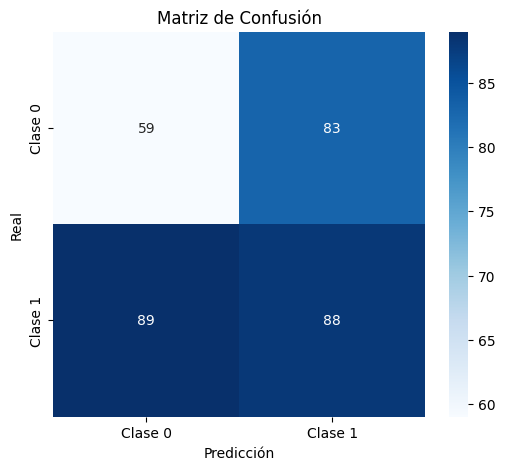


Informe de clasificación:
Precision : 0.51
Recall : 0.5
f1_score : 0.51
ROC-AUC: 0.46


In [202]:
accuracy = accuracy_score(y_val, clasificaciones)
print(f"Accuracy del modelo: {accuracy}")

# Mostrar la matriz de confusión
cm = confusion_matrix(y_val, clasificaciones)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
precision = precision_score(y_val, clasificaciones)
# Obtener recall para ambas clases
recall = recall_score(y_val, clasificaciones)
f1 = f1_score(y_val, clasificaciones)
roc_auc = roc_auc_score(y_val, clasificaciones)

print(f'Precision : {round(precision,2)}')
print(f'Recall : {round(recall,2)}')  # Aquí se muestra el recall para ambas clases
print(f'f1_score : {round(f1,2)}')
print(f'ROC-AUC: {round(roc_auc,2)}')

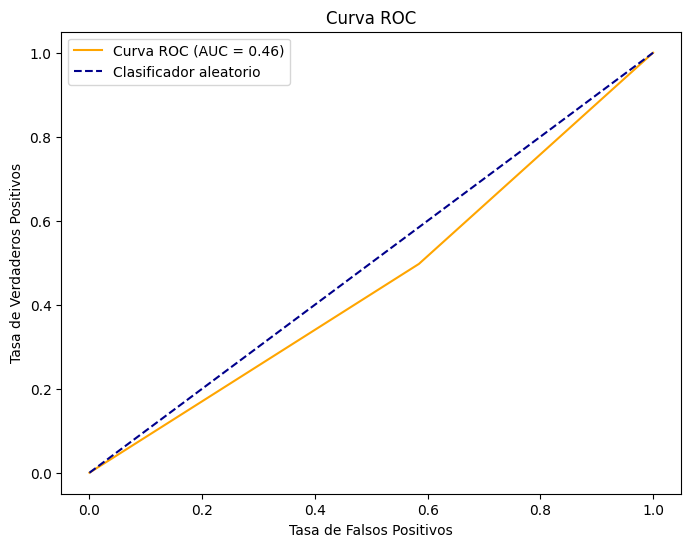

In [203]:
### Curva ROC
fpr, tpr, thresholds = roc_curve(y_val, clasificaciones)

# Graficar la curva ROC
plt.figure('ROC Regresion Logistica',figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Regresión logística

In [206]:

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 20),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100]
}

# Crear un modelo de regresión logística
model = LogisticRegression()

# Realizar la búsqueda de cuadrícula exhaustiva para encontrar los mejores hiperparámetros
random_search = RandomizedSearchCV(model,
                                   param_grid,
                                   cv=5,
                                   verbose=1,
                                   n_jobs=-1,
                                   scoring = 'f1',
                                   n_iter=10)

random_search.fit(X_train_smote, y_train_smote)

# Obtener los mejores hiperparámetros
best_params = random_search.best_params_

model_rl = LogisticRegression()

# Ajustar el modelo con los datos de entrenamiento
model_rl.fit(X_train_smote, y_train_smote)

# Encontrar las probabilidades para luego encontrar el umbral optimo.
y_para_encontrar_umbral = model_rl.predict_proba(X_train_smote)[:,1]

fpr, tpr, thresholds = roc_curve(y_train_smote, y_para_encontrar_umbral)

youden_index = tpr - fpr

# Encontrar el umbral que maximiza el índice de Youden
mejor_umbral_rl = thresholds[np.argmax(youden_index)]


#Calculo de predicciones conjunto de validación
y_prob_pred_rl = model_rl.predict_proba(X_val)[:,1]
y_pred_rl_val = (y_prob_pred_rl >= 0.5).astype(int)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


(array([11., 29., 27., 49., 40., 58., 41., 35., 21.,  8.]),
 array([0.11005117, 0.19369138, 0.27733159, 0.3609718 , 0.44461201,
        0.52825222, 0.61189243, 0.69553264, 0.77917286, 0.86281307,
        0.94645328]),
 <BarContainer object of 10 artists>)

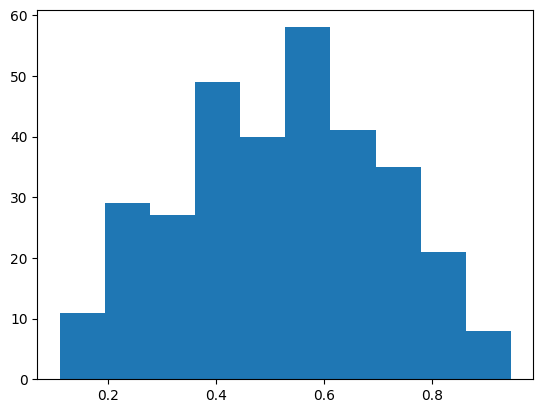

In [207]:
plt.hist(y_prob_pred_rl)

In [208]:
print(mejor_umbral_rl)

0.503072691854273


Accuracy del modelo: 0.6489028213166145


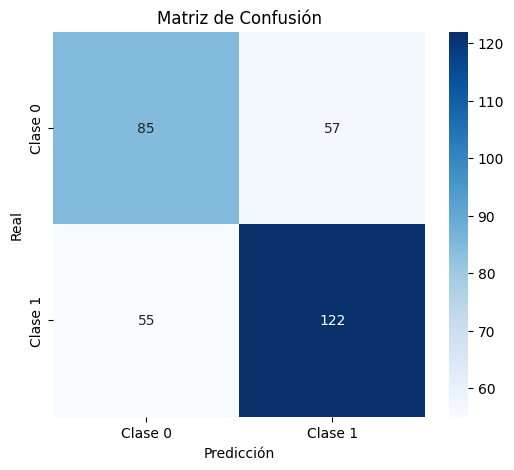


Informe de clasificación:
Precision : 0.68
Recall : 0.69
f1_score : 0.69
ROC-AUC: 0.64


In [209]:
accuracy = accuracy_score(y_val, y_pred_rl_val)
print(f"Accuracy del modelo: {accuracy}")

# Mostrar la matriz de confusión
cm = confusion_matrix(y_val, y_pred_rl_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
precision = precision_score(y_val, y_pred_rl_val)
# Obtener recall para ambas clases
recall = recall_score(y_val, y_pred_rl_val)
f1 = f1_score(y_val, y_pred_rl_val)
roc_auc = roc_auc_score(y_val, y_pred_rl_val)

print(f'Precision : {round(precision,2)}')
print(f'Recall : {round(recall,2)}')  # Aquí se muestra el recall para ambas clases
print(f'f1_score : {round(f1,2)}')
print(f'ROC-AUC: {round(roc_auc,2)}')

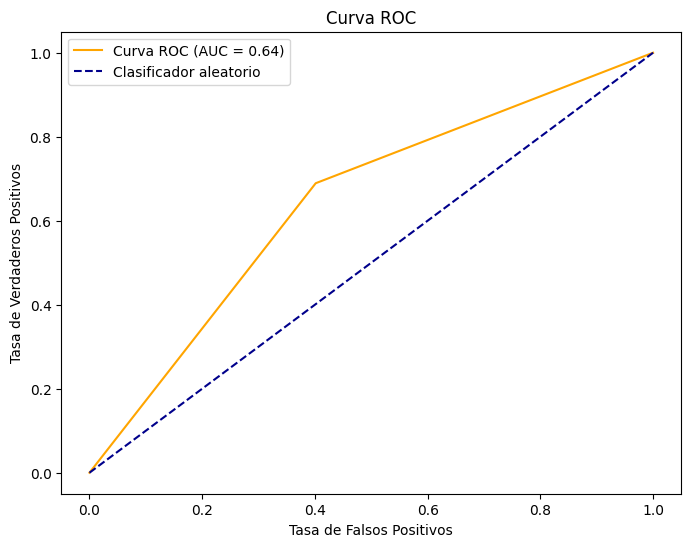

In [210]:
### Curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rl_val)

# Graficar la curva ROC
plt.figure('ROC Regresion Logistica',figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

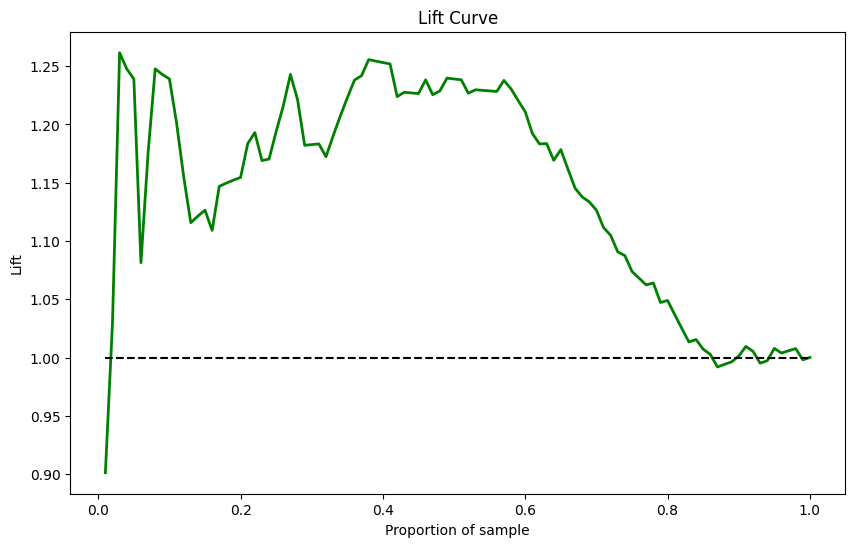

In [211]:
def plot_lift_curve(y_val, y_pred, step=0.01):
    # Create a DataFrame with real and predicted values
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred

    # Sort values by predicted probability
    aux_lift.sort_values('predicted', ascending=False, inplace=True)

    # X-axis values
    x_val = np.arange(step, 1 + step, step)

    # Ratio of positive instances in the data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)

    # Y-axis values
    y_v = []
    for x in x_val:
        num_data = int(np.ceil(x * len(aux_lift)))
        data_here = aux_lift.iloc[:num_data, :]
        ratio_ones_here = data_here['real'].sum() / len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

    # Plot the Lift Curve
    plt.figure(figsize=(10, 6))
    plt.plot(x_val, y_v, 'g-', linewidth=2)
    plt.plot(x_val, np.ones(len(x_val)), 'k--')
    plt.xlabel('Proportion of sample')
    plt.ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

# Example usage
# y_val: array of true labels
# y_pred: array of predicted probabilities
plot_lift_curve(y_val, y_pred_rl_val)




### XGBoost

In [ ]:
# Definimos el rango de hiperparámetros para XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': np.logspace(-3, 0, 20),
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 0.1, 0.01, 0.001]
}

# Crear el modelo base XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Realizar la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_smote, y_train_smote)

# Obtener los mejores hiperparámetros
best_params = random_search.best_params_

xgb_best = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb_best.fit(X_train_smote, y_train_smote)

# Obtener probabilidades para los datos de entrenamiento
y_train_proba = xgb_best.predict_proba(X_train_smote)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_train_smote, y_train_proba)

# Calcular el índice de Youden
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]


# Predecir con el umbral óptimo en el conjunto de validación
y_val_proba = xgb_best.predict_proba(X_val)[:, 1]
y_val_pred_xg = (y_val_proba >= 0.5).astype(int)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:47:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:47:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:47:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:47:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/carlos/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:47:46] WARNING: /workspace/sr

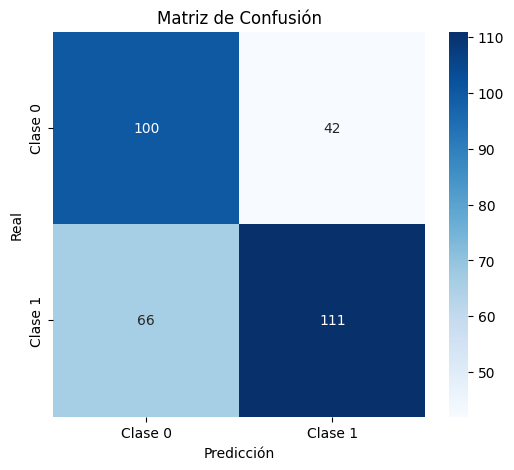


Informe de clasificación:
Precision : 0.7254901960784313
Recall : 0.6271186440677966
f1_score : 0.6727272727272727
Accuracy del modelo: 0.6614420062695925
ROC-AUC: 0.6656719980902364


In [216]:
# Mostrar la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred_xg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
precision = precision_score(y_val, y_val_pred_xg)
# Obtener recall para ambas clases
recall = recall_score(y_val, y_val_pred_xg)
f1 = f1_score(y_val, y_val_pred_xg)
roc_auc = roc_auc_score(y_val, y_val_pred_xg)

print(f'Precision : {precision}')
print(f'Recall : {recall}')  # Aquí se muestra el recall para ambas clases
print(f'f1_score : {f1}')
accuracy = accuracy_score(y_val, y_val_pred_xg)
print(f"Accuracy del modelo: {accuracy}")
print(f'ROC-AUC: {roc_auc}')

### KNN

In [218]:
# Definir el rango de hiperparámetros para KNN
param_grid = {
    'n_neighbors': range(1, 30),  # Número de vecinos a considerar
    'weights': ['uniform', 'distance'],  # Pesos de los vecinos
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métricas de distancia
}

# Crear el modelo base KNN
knn_model = KNeighborsClassifier()

# Realizar la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_grid,
    n_iter=10,  # Número de iteraciones para la búsqueda aleatoria
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_smote, y_train_smote)

# Obtener los mejores hiperparámetros
best_params = random_search.best_params_
print("Mejores hiperparámetros para KNN:", best_params)


# Ajustar el modelo KNN con los mejores hiperparámetros
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train_smote, y_train_smote)


# Obtener probabilidades para los datos de entrenamiento
y_train_proba = knn_best.predict_proba(X_train_smote)[:, 1]


# Predecir con el umbral óptimo en el conjunto de validación
y_val_proba = knn_best.predict(X_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros para KNN: {'weights': 'distance', 'n_neighbors': 23, 'metric': 'minkowski'}


Accuracy del modelo: 0.6363636363636364


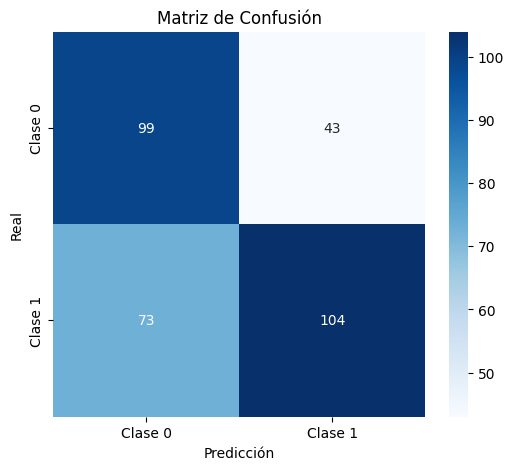


Informe de clasificación:
Precision : 0.7074829931972789
Recall : 0.5875706214689266
f1_score : 0.6419753086419753
ROC-AUC: 0.6423768600302379


In [219]:
accuracy = accuracy_score(y_val, y_val_proba)
print(f"Accuracy del modelo: {accuracy}")

# Mostrar la matriz de confusión
cm = confusion_matrix(y_val, y_val_proba)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
precision = precision_score(y_val, y_val_proba)
# Obtener recall para ambas clases
recall = recall_score(y_val, y_val_proba)
f1 = f1_score(y_val, y_val_proba)
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f'Precision : {precision}')
print(f'Recall : {recall}')  # Aquí se muestra el recall para ambas clases
print(f'f1_score : {f1}')
print(f'ROC-AUC: {roc_auc}')

## Comportamiento fuera de muestra

In [220]:
#Calculo de predicciones conjunto de productivo
y_prob_pred_rl_test = model_rl.predict_proba(X_test)[:,1]
y_pred_rl_val_test = (y_prob_pred_rl_test >= 0.5).astype(int)

Accuracy del modelo: 0.6875


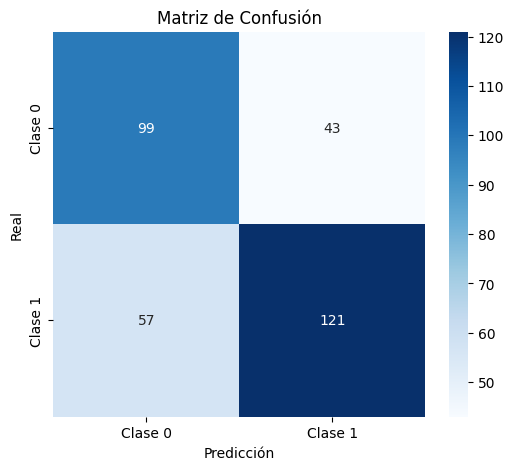


Informe de clasificación:
Precision (Clase 0, Clase 1): 0.7378048780487805
Recall (Clase 0, Clase 1): 0.6797752808988764
f1_score (Clase 0, Clase 1): 0.7076023391812866
ROC-AUC: 0.6884791897452128


In [221]:
accuracy = accuracy_score(y_test, y_pred_rl_val_test)
print(f"Accuracy del modelo: {accuracy}")

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_rl_val_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Informe de clasificación
print("\nInforme de clasificación:")
precision = precision_score(y_test, y_pred_rl_val_test)
# Obtener recall para ambas clases
recall = recall_score(y_test, y_pred_rl_val_test)
f1 = f1_score(y_test, y_pred_rl_val_test)
roc_auc = roc_auc_score(y_test, y_pred_rl_val_test)

print(f'Precision (Clase 0, Clase 1): {precision}')
print(f'Recall (Clase 0, Clase 1): {recall}')  # Aquí se muestra el recall para ambas clases
print(f'f1_score (Clase 0, Clase 1): {f1}')
print(f'ROC-AUC: {roc_auc}')